**Utility functions related to cost function minimizations**

The main function defined here to be heavily used elsewhere is **bbox_hessian_keyword_minimization()**.



<h1 id="tocheading">TABLE OF CONTENTS</h1>
<div id="toc"></div>

**Updates to the table of contents are periodic, but run the cell below to first start or force an update.**

In [1]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
$.getScript('make_table_of_contents.js')
"""

# Helper functions for the soft tanh() wall method for putting bounds on parameter values

These are functions that help with the soft tanh() wall method for implementing the parameter bounding box.

The basic idea of the soft tanh() method is the following:  Let's say we have a scalar function $f(x)$, and we want to find its minimum subject to $x_0 <= x <= x_1$.

Let's say that $m$ is the midpoint of the range, $m = (x_0+x_1)/2$, and $d$ is the width of the range, $d = x_1 - x_0$. We're going to use the function $g()$

$$
   g(x) = x_0 + (x_1-x_0)*\frac{1}{1 + \exp(-\frac{x-m}{d})}
$$

Note that $g()$ ranges from a strict minimum of $x_0$ to a strict maximum of $x_1$, and it is monotonic in $x$, so for any value of $x$ that is within the range, we can obtain $g^{-1}(x)$.

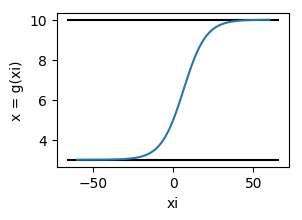

In [2]:
using PyPlot

function g(x, x0, x1)
    m = 0.5*(x0+x1)
    d = x1-x0
    
    return x0 + (x1-x0)./(1 + exp.(-(x-m)/d))
end

h = figure(1); clf(); h[:set_size_inches](3, 2); 
x0 = 3; x1 = 10; x = -60:0.1:60

plot(x, g(x, x0, x1), "-"); 

xlabel("xi"); ylabel("x = g(xi)"); hlines([x0, x1], xlim()[1], xlim()[2]); 

**Our strategy:**

Now here is our strategy: instead of minimizing the function $f(x)$ subject to the range constraints, we will instead  minimize the function $f(g(\xi))$ subject to *no* constraints on $\xi$. 

To start the minimization, if we wanted to start at $x = x_{seed}$, we first compute $\xi_{seed} = g^{-1}(x_{seed})$, and we start at that value of $\xi_{seed}$. That will correspond to having started at $x_{seed}$, as desired.

For every value of $\xi$ there is a corresponding value of $x = g(\xi)$. And no matter where $\xi$ ranges, its corresponding value of $x$ will be strictly bounded within the desired limits.  Note that 

$$
    \frac{{\rm d}f}{{\rm d}x} = \frac{{\rm d}f}{{\rm d}g} \cdot \frac{{\rm d}g}{{\rm d}\xi}
$$

Therefore, as $x$ approaches the rangle limits (which corresponds to $|\xi - m| >> d$), we will be approaching the flat part of $g()$ and therefore $\frac{{\rm d}g}{{\rm d}\xi}$ will approach zero and so will $\frac{{\rm d}f}{{\rm d}x}$: this is what prevents the search from going beyond the bounds. Note also that in each iteration of  bbox_hessian_keyword_minimization() we ask for the step that would minimize the cost function *given a certain step magnitude*. This means we will avoid directions that have little impact on the cost function.



**The helper functions are**:

## wallwrap()

Takes a dictionary of range limits, and a dictionary of current free range parameter values and returns a dictionary of the corresponding "walled" values, constrained to lie within the desired bounds. (I.e., puts values through tanh())

## vector_wrap()

does the same as pdict, except that instead of the dictionary of current free range parameter values, it takes a list of strings and a corresponding vector of values, and returns a vector.

## inverse_wall()

is the inverse of the above two operations: if passed a dictionary of ranges and a dictionary of constrained values, it returns a dictionary of the corresponding free range values. If passed a list of strings and a vector or the corresponding constrained values, returns a vector of the corresponding free-range, unconstrained values.



In [3]:
#@include_me optimization_utils.jl

include("general_utils.jl")
include("constrained_parabolic_minimization.jl")


"""
pdict = wallwrap(bdict, pdict)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, and pdict, a dictionary of symbols
to values (or, alternatively, an Array of (Symbol, value) tuples], goes through each of the symbols in 
bdict and modifies the corresponding value in pdict putting it through a tanh so the final output lies 
within the limits in bdict.  Returns the new pdict.  Makes a copy of pdict so as not to modify the original.
"""
function wallwrap(bdict, epdict)
    local pdict = two_level_copy(epdict)  # Must be very careful here! I got bit by the bug of forgetting that without
    # an explicit copy() call, Julia does not make copies of the contents of arrays or dictionaries, making it
    # easy to inadvertently modify something one did not intend to perturb.  Note the two_level_copy() call, 
    # necessary to make sure we don't mess up the content of the caller's dictionary.
    
    if typeof(pdict)<:Array
        pdict = Dict(pdict)
    end

    allkeys = keys(bdict)

    for k in allkeys
        local bbox = bdict[k]
        d = 0.5*(bbox[2] - bbox[1])
        m = 0.5*(bbox[2] + bbox[1])

        pdict[k] = bbox[1] + d*(tanh((pdict[k]-m)/d)+1)
    end
    return pdict
end

    
"""
params = vector_wrap(bbox, args, eparams)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, args, an array of strings representing
symbols, and params, an array of values corresponding to the args list, puts each param that has an entry 
in bdict through the tanh-walling mechanism, and returns the result. Does not modify the contents of the 
original params vector (or bdict or args).
"""
function vector_wrap(bbox, args, eparams)
    local params = two_level_copy(eparams)
    pdict = wallwrap(bbox, make_dict(args, params))
    i=1; j=1
    for i=1:length(args)
        if typeof(args[i])<:Array
            params[j:j+args[i][2]-1] = pdict[Symbol(args[i][1])]
            j += args[i][2]-1
        else
            params[j] = pdict[Symbol(args[i])]
        end
    j = j+1
    end
    return params
end


"""
params = inverse_wall(bdict, args, wparams)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, args, an array of strings representing
symbols, and wparams, an array of values corresponding to the args list where each param that has an entry 
in bdict has alreadt been through the tanh-walling mechanism, UNwalls the ones that have a bdict entry and
returns the result. Does not modify the contents of the original params vector (or bdict or args).
"""
function inverse_wall(bdict, args, wparams)
    local params = two_level_copy(wparams)
    pdict = inverse_wall(bdict, make_dict(args, params))
    i=1; j=1
    for i=1:length(args)
        if typeof(args[i])<:Array
            params[j:j+args[i][2]-1] = pdict[Symbol(args[i][1])]
            j += args[i][2]-1
        else
            params[j] = pdict[Symbol(args[i])]
        end
        j = j+1
    end
    return params    
end

    
"""
pdict = inverse_wall(bdict, wdict)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, and wdict, a dictionary of symbols to values
(or vectors of values)  UNwalls the ones that have a bdict entry and
returns the result. Does not modify the contents of any dictionaries.
"""
function inverse_wall(bdict, wdict)
    local pdict = two_level_copy(wdict)

    allkeys = keys(bdict)
    for k in allkeys
        local bbox = bdict[k]
        d = 0.5*(bbox[2] - bbox[1])
        m = 0.5*(bbox[2] + bbox[1])

        pdict[k] = m + d*0.5*log((pdict[k]-bbox[1])./(2*d - pdict[k] + bbox[1]))
    end
    return(pdict)
end
  

inverse_wall

# bbox_trust_region_hessian_keyword_minimization


In [4]:
#@include_me optimization_utils.jl


"""
function adaptive_gradient_minimization(seed, func; start_eta=0.1, tol=1e-6, maxiter=400, verbose=false)

NEEDS DOCMENTING
"""

function adaptive_gradient_minimization(seed, func; start_eta=0.1, tol=1e-6, maxiter=400,
    verbose=false)
    
    params = seed
    eta = start_eta

    out = DiffBase.GradientResult(params)
    ForwardDiff.gradient!(out, func, params)
    cost = DiffBase.value(out)
    grad = DiffBase.gradient(out)

    for i in [1:maxiter;]
        new_params = params - eta*grad

        ForwardDiff.gradient!(out, func, new_params)
        new_cost = DiffBase.value(out)
        new_grad = DiffBase.gradient(out)

        if abs(new_cost - cost) < tol
            break
        end
    
        if new_cost >= cost
            eta = eta/2
        else
            eta = eta*1.1
            params = new_params
            cost = new_cost
            grad = new_grad
        end

        if verbose
            @printf "%d: eta=%.3f cost=%.4f ps=[" i eta cost 
            for p in [1:length(params);]
                @printf "%.3f" params[p]
                if p<length(params) @printf ", "; end
            end
            @printf "]\n"
        end
    end
    
    return params
end


#############################################################################
#                                                                           #
#                   TRUST_REGION_HESSIAN_MINIMIZATION                       #
#                                                                           #
#############################################################################



"""
function trust_region_Hessian_minimization(seed, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false)

(below, x stands for delta_x, the step from the current x=x0 position at which the cost = const)

cost = 0.5*x'*H*x + grad*x + const

dcost/dx = H*x + grad  ;   dcost/dx = 0  ==> x =  - inv(H)*grad

Trust-region says have a parameter lambda, and replace H with hat{H} = H +  I/eta.  
When eta is very large, this is equivalent to a straight Newton method jump, 
because hat{H} ~= H.  But when eta is small, this is more like a small gradient
descent step, because for small eta inv(hat{H}) ~= eta and therefore the delta x is like 
-eta*grad.  So, if the cost function is going down, make eta larger, and if it is going
up, make eta a lot smaller. Just like we do in other adaptive methods

PARAMETERS:
===========

seed        column vector, representing the starting value of the parameters.

func        Function that takes a vector and returns a scalar.  If you want to
            work with a function that tales more parameterrs and returns more than one 
            output, you can use something like

                    x -> orig_func(x, other_params)[1]

            You only need the "[1]" part if the orig_func returns more outputs than a scalar. 

OPTIONAL PARAMETERS:
====================

start_eta=10    Starting value of eta.  It's good to start with somethibg biggish, if it is
                too much, it'll quickly get cut down.

tol=1e-15       Numerical tolerance. If a proposed jump produces a change in func that is less than
               this, the minimization stops.

maxiter=400    Maximum number of iterations to do before stopping

verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

RETURNS:
========

params       A vector the size of seed that has the last values of the minimizing parameters for func

"""
function trust_region_Hessian_minimization(seed, func; start_eta=10, tol=1e-15, maxiter=400,
    verbose=false, verbose_level=1)

    params = seed
    eta = start_eta

    cost, grad, hess = vgh(func, params)
    if verbose && verbose_level >= 2
        @printf("Initial cost, grad, hess:\n")
        print_vector_g(:cost)
        print_vector_g(:grad)
        print_vector_g(:hess)
    end
    

    for i in [1:maxiter;]
        hathess    = hess + eye(length(grad), length(grad))/eta        
        new_params = params - inv(hathess)*grad
        new_cost, new_grad, new_hess = vgh(func, new_params)
            
        if abs(new_cost - cost) < tol
            break
        end

        if new_cost >= cost
            eta = eta/2
            costheta = NaN
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            @printf "%d: eta=%.3f cost=%.4f costheta=%.3f ps=" i eta cost  costheta
            print_vector(params)
            @printf "\n"
        end
    end
    
    return params, cost
end

trust_region_Hessian_minimization

# bbox_hessian_keyword_minimization() function()

The main function here does parameter optimization, i.e. searching for the minimum of a scalar function of a vector-valued set of payameters. It uses ForwardDiff to compute and use information about gradients and Hessians, and uses the soft tanh() wall method to keep selected parameters strictly within desired limits during the search.

The main search function, called bbox_hessian_keyword_minimization(), takes four obligatory parameters (and many optional ones, see its documentation below for details):

* seed, a vector with the starting value of some parameters
* args, a list of strings, same length as seed, indicating the parameter names associated with each value in seed. 
* func, a function that returns a scalar and takes only keyword-value argument pairs. All of the strings in args must indicate keyword names for func() that func() knows about.
* bbox, a dictionary where each key is a Symbol indicating a parameter name, and the values are two-long vectors, whose elements indicate the desired minimum and maximum of the range for that parameter, respectively. Any key in this dictionary must also be, in string form, in args. But not all entries in args, need be in bbox, the missing ones are assumed to have no bounds. bbox could even be an empty dictionary, indicating no bounds on any parameter.

bbox_hessian_keyword_minimization() will start from seed, will search for parameter values that minimize fun, and will return those, along with a variety of information that is diagnostic regarding the search.


The function minimizes a scalar function $f()$ of keyword-value pairs, by searching for the parameter values that produce the smallest output. At each step of the minimization, uses ForwardDiff to compute the gradient $\bf g$ and the Hessian $H$ at the current set of parameter values ${\bf p_0}$; and then uses constrained_parabolic_minimization() to find the the parameter values ${\bf p}$, such that $|{\bf p} - {\bf p_0}| <= \eta$, that would minimize the parabolic approximation to the cost function

$$
J({\bf p}) = J({\bf p_o}) + {\bf g}^T ({\bf p} - {\bf p_0}) + \frac{1}{2} ({\bf p} - {\bf p_0})^T \cdot H \cdot ({\bf p} - {\bf p_0})
$$

If the cost $f({\bf p}) < f({\bf p_0})$, then the step is accepted, the current parameter values become ${\bf p}$ and $\eta$ is increased slightly. Otherwise the step is not accepted, current parameter values are not changed, and $\eta$ is cut by a factor of 2.  Note than when $\eta$ is very small, this becomes gradient descent. It is only when $\eta$ is larger that the Hessian begins to play a role.

A parameter step for which $|{\bf p} - {\bf p_0}| < \eta$ is called a "Newton" jump (it is Newton's method). A step in which $|{\bf p} - {\bf p_0}| = \eta$ is called a "constrained" jump. If the `verbose=true option` is selected, then the diagnostic information printed out at each step includes the cosine of the angle between the step taken and the gradient (when this is close to -1, we're doing gradient descent; far from -1, we're using the Hessian information).

**FAILURE MODES:**  At each step of the search iteration, constrained_parabolic_minimization(), which itself involves a search, may fail. For diagnostics on this, a matrix called `cpm_traj` is returned. Its first row is the number of iterations run by constrained_parabolic_minimization()'s internal search, at each step of the overall search. If this number is equal to the maximum requested (currently hardcoded as 500 iterations), that means that constrained_parabolic_minimization() returned only because it ran into its maximum iteration limit, not because it was successful, and is therefore a sign of a step that may have been taken in a poor direction.

**RETURNING MULTIPLE OUTPUTS IN $f()$:** In the implementation below, $f()$ must either return a scalar, or the first output it returns must be a scalar. That scalar is what will be minimized. The trajectory across the minimization of any further outputs that f() returns will be available in ftraj (see help documentation for `bbox_Hessian_keyword_minimization()` below). **Note that you might want to convert some of those outputs into
Float64s, so they don't return as ForwardDiff Duals.**  See example in the cell below.


In [12]:
#@include_me optimization_utils.jl


# Julia 0.5 returns an error if you run Pkg.installed on a package that has not been installed
try
    Pkg.installed("JLD")
catch
    Pkg.add("JLD")
end

# Julia 0.6 does not crash but returns a Void if you run Pkg.installed on a package that has not been installed
if isa(Pkg.installed("JLD"), Void)
    Pkg.add("JLD")
end


using JLD
using MAT


######################################################
#                                                    #
#         BBOX_HESSIAN_KEYWORD_MINIMIZATION          #
#                                                    #
######################################################




"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; start_eta=10, tol=1e-6, 
maxiter=400, frac_cost_threshold = 0.5, stopping_function = nothing, verbose=false, report_file="")

Like constrained_Hessian_minimization, but uses keyword_hessian!(). 

# PARAMETERS:

- seed        column vector, representing the starting value of the parameters.

- args        List of strings identifying parameters for differentiation, e.g., ["const_E", "w_self]

- bbox        If softbox=true (the default), should then be a Dict of Symbol=>[minval maxval] entries. An entry
            in this Dict indicates that the corresponding parameter is to be bounded, as indicated by the associated 
            [minval maxval] vector. The bbox dictionary can have fewer entries than the number of parameters, and its
            default value is Dict(), indicating an unbounded search.
                If softbox=false, then bbox should be an nargs-by-2 matrix indicating the range for each argument,
            with the minima (first column) and maxima (second column), and entries for ALL parameters.

- func      func must take only optional keyword args, and must 
            take nderivs=0, difforder=0  and declare any new matrices using ForwardDiffZeros() instead of zeros().
            [THE ABOVE PART OF THE DOCUMENTATION MUST BE UPDATED FOR JULIA 0.6]
            func must either return a scalar, or the first output it returns must be a scalar. 
            That scalar is what will be minimized. The trajectory across the minimization of 
            any further outputs that f() returns will be available in ftraj (see RETURNS below)


# OPTIONAL PARAMETERS:

- start_eta    Starting value of the radius.  It's good to start with somethibg biggish, if it is
             too much, it'll quickly get cut down.

- tol=1e-6     Numerical tolerance. If a proposed jump produces a change in func that is less than
             this, the minimization stops.

- maxiter=400  Maximum number of iterations to do before stopping

- frac_cost_threshold   When the algorithm is going to take a step, it first checks whether this will reduce the cost.
                If the answer is "no" then the step is not taken, and the step size is halved. 
                Small step sizes will make the algorithm gradient-descent-like, so if the step size keeps 
                getting smaller, eventualluy we get to simple gradient descent. If the cost will be reduced, 
                another check is done, comparing to the expected cost change, from the quadratic approximation. 
                If the ratio of the actual cost reduction / expected cost reduction is less than "frac_cost_threshold", 
                then the step is not taken and the step size is halved. Otherwise, the  step is taken, and step 
                size goes up by 1.1.  A frac_cost_threshold=0 makes both of these checks equivalent.

- stopping_function   If present, this should be a function that returns a boolean, that can take as 
                keyword-value pairs the same args, pars that are given to func, and also takes keyword-value "cost"
                and keyword_value "func_out". The value of cost will be the latest scalar value of func, and the
                value of "func_out" will be a tuple with any further returns from func. `stopping_function()` is run 
                each iteration, and if it returns true, the minimization is stopped.

- verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

- verbose_level   If less than 2, regular verbose output, if 2 or greater, very verbose, for debugging.

- softbox       If true, then bbox must be a Dict() and we use the tanh() mechanism for putting a fixed limit
                on the parameters. NO LONGER SUPPORTING ANYTHING OTHER THAN softbox=true (which is the default)

- report_file   If non-empty, at each iteration timestep will write into this file outputs trajectory, 
                (which contains eta, cost, and parameters), cpm_traj, and ftraj (which contains gradient, hessian, 
                and further cost function outputs).  The file must be a JLD file, and so will end with a .jld extension.
                To load the saved dictionary, simply do D = load(filename)  (we have already called "using JLD" for you.)



# RETURNS:

- params       A vector the size of seed that has the last values of the minimizing parameters for func
- trajectory   A (2+length(params))-by-nsteps matrix. Each column corresponds to an iteration step, and contains
                 the value of eta used, the cost, and the value of the parameters at that iteration
- cost         Final value of objective function
- cpm_traj     A 4-by-nsteps matrix, containing reports from the contrained parabolic minimization at each timestep.
             The first row is niters (how many iterations cpm's 1-d minimization ran for) and the second row is
            Dlambda, the last change in the parameter being minimized in cpm's internal search, 
            the third row is the squared difference between the returned and desired radius (should be very small),
            and the fourth row is cost change expected under the quadratic approximation

- ftraj     Further components for the trajectory, will be an Array{Any}(3, nsteps). First row is gradient,
            second row is Hessian, third row is second-and-further outputs of func, each one at each step of
            the minimization. **NOTE** that if these further outputs contain variables that are being minimized, 
            they'll come out as ForwardDiff Duals, which you might not want!  So, for example, you might want to
            convert vectors and matrices into Float64s before returning them in those extra outputs. E.g.,
            if you want to return sum(err.*err) as the scalar to be minimized, and also return err, in your 
            cost function you would write   " return sum(err.*err), Array{Float64}(err) ".   That way the first,
            scalar output can still be differentiated, for minimization, and the second one comes out in readable form.



# EXAMPLE:  (see also a more complete example in Cost Function Minimization and Hessian Utilities.ipynb)

```
function tester(;x=5, y=10, z=20, nderivs=0, difforder=0)
    return x^2*y + z/tanh(y)
end

params, trajectory = bbox_Hessian_keyword_minimization([0.5, 0.5], ["x", "y"], [1.1 2 ; 1.1 4], tester, 
    verbose=true, tol=1e-12, start_eta=1);
```


"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; start_eta=0.1, tol=1e-6, maxiter=400,
    frac_cost_threshold = 0.5, stopping_function = nothing,
    verbose=false, verbose_level=1, verbose_every=1, softbox=true, hardbox=false, report_file="")

    # --- check that saving will be done to a .jld file ---
    if length(report_file)>0 && splitext(report_file)[2] != ".jld"
        if splitext(report_file)[2] == ""
            report_file = report_file * ".jld"
        else
            error("Sorry, report_file can only write to JLD files, the extension has to be .jld")
        end
    end

    
    # --------- Initializing the trajectory trace and function wrapper--------
 
    traj_increment = 100
    params = 0  # Make sure to have this here so that params stays defined beyond the try/catch
    if ( !(typeof(bbox)<:Dict) ); error("Currently only supporting softbox=true, bbox must be a Dict"); end;
    try
        params = copy(inverse_wall(bbox, args, seed))
    catch
        error("Were all initial param values within the indicated walls?")
    end
    eta = start_eta
    trajectory = zeros(2+length(params), traj_increment); cpm_traj = zeros(4, traj_increment)
    
    ftraj = Array{Any}(3,0)  # will hold gradient, hessian, and further_out,  per iteration

    further_out =[];  # We define this variable here so it will be available for stashing further outputs from func
    stopping_func_out = false;   # Default value of stopping_func()
    
    # Now we define a wrapper around func() to do three things: (a) wallwrap parameters using the softbox method;
    # (b) return as the desired scalar the first output of func; (c) stash in further_out any further outputs of func
    internal_func = (;pars...) -> begin
        fresults = func(;wallwrap(bbox, pars)...)   # note use of bbox external to this begin...end
        if typeof(fresults)<:Tuple
            answer = fresults[1]
            further_out = fresults[2:end]
        else
            answer = fresults
        end
        return answer  # we assume that the first output of func() will always be a scalar, and that's what we return for ForwardDiff
    end

    # --------- END Initializing the trajectory trace --------

    if verbose
        @printf "%d: eta=%g ps=" 0 eta 
        print_vector(vector_wrap(bbox, args, params))
        @printf "\n"
    end
    
    if softbox
        if !(typeof(bbox)<:Dict); error("bhm: If softbox=true, then bbox must eb a Dict"); end
        cost, grad, hess = keyword_vgh(internal_func, args, params)  # further_out will be mutated
    elseif hardbox
        error("Sorry, no longer supporting hardbox=true")
    else
        error("Sorry, no longer supporting softbox=false")
    end
        
    chessdelta = zeros(size(params))
    expected_cost_delta = 0   # this will be the quadratically expected cost change, either the Newton prediction or the constrained prediction
    hess_cost_delta     = 0   # this will hold the Newtorn prediction
    chess_cost_delta    = 0   # this will hold the constrained prediction
    
    i=0  # here so variable i is available outside the loop
    for i in [1:maxiter;]
        if i > size(trajectory, 2)
            trajectory = [trajectory zeros(2+length(params), traj_increment)]
            cpm_traj   = [cpm_traj   zeros(4, traj_increment)]
        end
        trajectory[1:2, i]   = [eta;cost]
        trajectory[3:end, i] = vector_wrap(bbox, args, params)
        ftraj = [ftraj [grad, hess, further_out]]

        if length(report_file)>0
            save(report_file, Dict("traj"=>trajectory[:,1:i], "cpm_traj"=>cpm_traj[:,1:i], "ftraj"=>ftraj))
        end
        
        hessdelta  = - inv(hess)*grad
        hess_cost_delta = 0.5 * hessdelta' * hess * hessdelta + grad'*hessdelta   # Netwon prediction for how much cost should change    
        try
            if verbose && verbose_level >= 2
                @printf("bhm: about to try cpm with grad : "); print_vector_g(grad); print("\n")
                @printf("bhm:   hess :"); print_vector_g(hess[:]); print("\n");
            end
            if verbose && verbose_level >= 2
                cpm_out = constrained_parabolic_minimization(hess, grad'', eta, 
                    maxiter=500, tol=1e-20, do_plot=true, verbose=true)                
            else
                cpm_out = constrained_parabolic_minimization(hess, grad'', eta, maxiter=500, tol=1e-20)
            end
            chess_cost_delta = cpm_out[2]
            chessdelta = cpm_out[1]; 
            
            cpm_traj[1,i] = cpm_out[5]; cpm_traj[2,i] = cpm_out[6]; #  niters and Dlambda
            cpm_traj[3,i] = cpm_out[4]; cpm_traj[4,i] = cpm_out[2]; #  radius error and quadratically predicted change in J
            jumptype = "not failed"
        catch y
            if isa(y, InterruptException); throw(InterruptException()); end  # External interrupts should not be catchable
            jumptype = "failed"
            if verbose
                @printf "Constrained parabolic minimization failed with error %s\n" y
                @printf "\n"
                @printf "eta was %g\n" eta
                @printf "grad was\n"
                print_vector(grad)
                @printf "\n\nhess was\n"
                for k in [1:length(grad);]
                    print_vector(hess[k,:])
                    @printf "\n"
                end
                @printf "\n"
                matwrite("error_report.mat", Dict("grad"=>grad, "hess"=>hess, "eta"=>eta))
            end
            break
        end

        if norm(hessdelta) <= eta
            new_params = params + hessdelta
            jumptype = "Newton"
            expected_cost_delta = hess_cost_delta
        elseif jumptype != "failed" 
            new_params = params + chessdelta
            jumptype  = "constrained"
            expected_cost_delta = chess_cost_delta
        end

        if jumptype != "failed"
            new_cost, new_grad, new_hess = keyword_vgh(internal_func, args, new_params)   # further_out may mutate
            if stopping_function != nothing
                stopping_func_out = stopping_function(; cost=cost, func_out=further_out, 
                    make_dict(args, new_params)...)
            end
            if verbose && verbose_level >=2
                @printf("bhm: had new_params = : "); print_vector_g(vector_wrap(bbox, args, params)); print("\n");
                @printf("bhm: and my bbox was : "); print(bbox); print("\n")
                @printf("bhm: and my wallwrap output was : "); print(wallwrap(bbox, make_dict(args, new_params))); print("\n")
                @printf("bhm: and this produced new_grad : "); print_vector_g(new_grad); print("\n")
                @printf("bhm:   new_hess :"); print_vector_g(new_hess[:]); print("\n");                                        
            end
            
            if abs(new_cost - cost) < tol || eta < tol || stopping_func_out
                if verbose
                    @printf("About to break -- stop_func_out = %s, tol=%g, new_cost-cost=%g, eta=%g\n", 
                        stopping_func_out, tol, new_cost-cost, eta)
                end
                break
            end
        end

        if jumptype == "failed" || cost <= new_cost || (new_cost - cost)/expected_cost_delta <= frac_cost_threshold  
            if verbose
                @printf("eta going down: ")
                if jumptype=="failed"; @printf("jtype=failed");
                else                   @printf("cost (new-old)/expect = %.3f", (new_cost - cost)/expected_cost_delta)
                end
                @printf(" new_cost-cost=%g and jumptype='%s'\n", new_cost-cost, jumptype)
                if verbose_level >= 2
                    nwp = vector_wrap(bbox, args, new_params); wp = vector_wrap(bbox, args, params)
                    @printf("   vvv: proposed new params were : "); print_vector_g(nwp); print("\n")
                    @printf("   vvv: proposed delta params was : "); print_vector_g(nwp-wp); print("\n")
                    @printf("   vvv: grad was : "); print_vector_g(grad); print("\n")
                    costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))
                    @printf("   vvv: costheta of proposed jump was %g\n", costheta)
                end
            end
            eta = eta/2
            costheta = NaN
            if eta < tol || stopping_func_out
                if verbose
                    @printf("About to break -- stop_func_out = %s, tol=%g, new_cost-cost=%g, eta=%g\n", 
                        stopping_func_out, tol, new_cost-cost, eta)
                end
                break
            end
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            if rem(i, verbose_every)==0
                @printf "%d: eta=%g cost=%g jtype=%s costheta=%.3f ps=" i eta cost jumptype costheta
                print_vector_g(vector_wrap(bbox, args, params))
                @printf "\n"
                if verbose_level >= 3
                    @printf "    At this point, grad is ="
                    print_vector_g(grad)
                    @printf "\n"                
                end
            end
        end
    end

    trajectory = trajectory[:,1:i]; cpm_traj = cpm_traj[:,1:i]
    if length(report_file)>0
        save(report_file, Dict("traj"=>trajectory, "cpm_traj"=>cpm_traj, "ftraj"=>ftraj))
    end
    
    return vector_wrap(bbox, args, params), trajectory, cost, cpm_traj, ftraj
end

bbox_Hessian_keyword_minimization

## Basic example of using bbox_Hessian_keyword_minimization()

We'll fit a sigmoid to some data generated from a sigmoid with noise.

In [27]:
pygui(true)

sr = Int64(round(time()*1000))
# sr = 1510162002784 # For these values of sr
# sr = 1509561656447 # when start_eta=1, the threshold quickly goes very positive and the minimization gets stuck
#
# sr = 1510164239381   # For this value, it gets stuck at a very small inverse slope param... don't know why
srand(sr)


npoints = 1000; # srand(400)
args = ["baseline", "amplitude", "threshold", "slope"]

# Generating values for our four params:
params = [1 5 0.5 0.8]

# Make some points and plot them
x = rand(npoints, 1)*6-3
y = params[1] + params[2]*0.5*(tanh.((x-params[3])/params[4])+1) + randn(npoints,1)*2
figure(1); clf();
plot(x, y, ".")

# Starting values for the four params. Plot the corresponding curve they generate
seed = [8, 3.1, 0, 0.02]
xx = -3:0.01:3
plot(xx, seed[1] + seed[2]*0.5*(tanh.((xx-seed[3])/seed[4])+1), "g-")

if FDversion() < 0.6
    # If using ForwardDiff version < 0.6  (e.g., with Julia 0.5.2) --------
    #
    # Cost function.  Note that it takes nderivs and difforder as parameters. First output is the scalar
    # that will be minimized, and we also returns a second output whose trajectory will be stashed 
    # by bbox in ftraj as a diagnostic during the minimization.
    function JJ(x, y; baseline=0, amplitude=1, threshold=0, slope=1, do_plot=false, fignum=1, clearfig=true,
        nderivs=0, difforder=0)

        if do_plot
            figure(fignum);
            if clearfig; clf(); end;
            xx = -3:0.01:3; x2=ForwardDiffZeros(size(xx,1), size(xx,2), nderivs=nderivs, difforder=difforder)
            for i=1:length(xx); x2[i]=xx[i]; end; xx= x2

            plot(x, y, ".")
            plot(xx, baseline + amplitude*0.5*(tanh((xx-threshold)/slope)+1), "r-")
        end

        yhat =  baseline + amplitude*0.5*(tanh((x-threshold)/slope)+1) 
        err = yhat - y
        return sum(err.*err), Array{Float64}(err)    # Note first output, the scalar to be minimized,
        # may be ForwardDiff Duals during the minimization, which is fine, so it can be differentiated.
        # The second one we cast into regular Float64 so it comes out readable.
    end
else 
    # If using ForwardDiff version >= 0.6  (e.g., with Julia 0.6) --------
    #
    # Cost function.  Note that it takes nderivs and difforder as parameters. First output is the scalar
    # that will be minimized, and we also returns a second output whose trajectory will be stashed 
    # by bbox in ftraj as a diagnostic during the minimization.
    function JJ(x, y; baseline=0, amplitude=1, threshold=0, slope=1, do_plot=false, fignum=1, clearfig=true)

        if do_plot
            figure(fignum);
            if clearfig; clf(); end;
            xx = -3:0.01:3; x2=zeros(get_eltype((baseline,amplitude,threshold,slope)), size(xx,1), size(xx,2))
            for i=1:length(xx); x2[i]=xx[i]; end; xx= x2

            plot(x, y, ".")
            plot(xx, baseline + amplitude*0.5*(tanh.((xx-threshold)/slope)+1), "r-")
        end

        yhat =  baseline + amplitude*0.5*(tanh.((x-threshold)/slope)+1) 
        err = yhat - y
        return sum(err.*err), get_value(err)    # Note first output, the scalar to be minimized,
        # may be ForwardDiff Duals during the minimization, which is fine, so it can be differentiated.
        # The second one we use get_value to turn into regular Float64 array so it comes out readable.
    end

end


if ~isdir("Trash"); mkdir("Trash"); end;  # we're going to put the iteration-step by iteration-step report file there

bbox = Dict(:baseline=>[-2, 10], :slope=>[0.001 5])
func = (;pars...) -> JJ(x, y; do_plot=false, pars...)

stopping_func = (;cost=0, func_out=[], pars...) -> return cost<1500;   # Make that a high number and it'll stop early

opars, traj, cost, cpm_traj, ftraj = bbox_Hessian_keyword_minimization(seed, args, bbox, func, 
frac_cost_threshold = 0.5, stopping_function = stopping_func,
verbose=false, verbose_level=2, softbox=true, start_eta=0.1, report_file="Trash/example_report.jld")

# Note that the gradient at step i of the minimization will be available as ftraj[1,i], the hessian will be 
# in ftraj[2,i], and the error vector, which is the first of the extra outputs of JJ(), will be in ftraj[3,i][1].
# In our example JJ() produced only one extra output; a second extra output would be in ftraj[3,i][2], and so on.

# Plot the resulting curve, and report both final and generating params
figure(1);
plot(xx, opars[1] + opars[2]*0.5*(tanh.((xx-opars[3])/opars[4])+1), "r-")
[opars' ; params]
xlabel("x"); ylabel("y"); title("green is sigmoid with starting params, red is end")


figure(2); clf();
ax1 = subplot(2,1,1)
plot(cpm_traj[4,:], ".-")
plot(traj[2,2:end] - traj[2,1:end-1], ".-")
grid("on")
remove_xtick_labels()
legend(["expected cost change", "actual cost change"])

subplot(2,1,2)
plot((traj[2,2:end] - traj[2,1:end-1])./cpm_traj[4,1:end-1], ".-")
plot(traj[1,2:end]./traj[1,1:end-1], ".-")
grid("on")

legend(["actual/expected cost change", "fractional change in eta"])

@printf("Final costs were: "); print_vector_g(traj[2,end-3:end]); print("\n")

Final costs were: [4574.67, 4574.67, 4529.32, 4495.3]


In [25]:
traj[2,end-3:end]

4-element Array{Float64,1}:
 4448.3 
 4438.15
 4437.78
 4437.78

In [ ]:
# Run this cell if you want to overlay, step by step, the result of the fit at that step.

figure(1); 
for i=1:size(traj,2)
    tpars = traj[3:end,i]
    plot(xx, tpars[1] + tpars[2]*0.5*(tanh.((xx-tpars[3])/tpars[4])+1), "r-")
end


In [57]:
value, grad, hess = keyword_vgh((;pars...) -> func(;pars...)[1], args, [opars[1], opars[2], opars[3], opars[4]])

(4527.677869931307, [5.07651e-8, 2.61774e-8, -6.0073e-5, 2.03845e-5], [2000.0 693.379 -2625.9 678.824; 693.379 692.583 -1023.2 91.1165; -2625.9 -1023.2 1.83051e6 -3.31238e5; 678.824 91.1165 -3.31238e5 2.68709e5])

In [59]:
D,V = eig(hess)

([393.204, 2294.79, 2.01362e5, 1.89786e6], [0.396374 0.918088 0.000710389 0.00142884; -0.918089 0.396374 -0.000568522 0.00053861; -8.9677e-5 0.00140966 0.199244 -0.979949; -0.000801741 -0.000722198 0.97995 0.199243])